# Bank term deposit subscription

In [36]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

In [2]:
df = pd.read_csv('banking.csv')
df.shape

(41188, 21)

### Data exploration

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [5]:
cat_features = []
num_features = []

for column in df.columns:
    if df[column].dtype == 'O':
        cat_features.append(column)
        print(column)
    else:
        num_features.append(column)

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome


Checking the different categories for the categorical features

In [6]:
for feature in cat_features:
    print('\n',feature)
    print(df[feature].unique())


 job
['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']

 marital
['married' 'single' 'divorced' 'unknown']

 education
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']

 default
['unknown' 'no' 'yes']

 housing
['yes' 'no' 'unknown']

 loan
['no' 'yes' 'unknown']

 contact
['cellular' 'telephone']

 month
['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec']

 day_of_week
['thu' 'fri' 'tue' 'mon' 'wed']

 poutcome
['nonexistent' 'success' 'failure']


Checking the distribution of the target variable

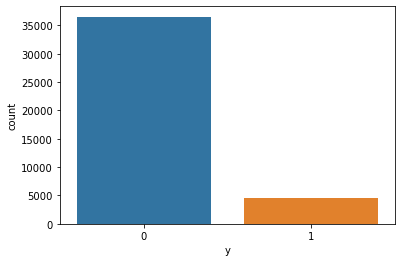

In [7]:
sns.countplot(data = df, x = 'y');

In [8]:
pd.DataFrame({'y':df.y.unique(),'count':df.y.value_counts(),'perc':round(df.y.value_counts(normalize = True)*100,2)})

,y,count,perc
0,0,36548,88.73
1,1,4640,11.27


In [10]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

### Feature reduction and dummies 

Reducing the number of features for the education category, as Logistic Regression doesn't deal well with a high number of different categories

In [11]:
df.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [12]:
basic = ['basic.4y','basic.6y','basic.9y']
df['education'] = np.where(df['education'].isin(basic), 'basic', df['education'])

In [13]:
df.education.unique()

array(['basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

Getting dummies for categorical features, dropping first to reduce columns and correlation among columns

In [14]:
df_ = pd.get_dummies(df, drop_first = True)

In [ ]:
df_.head()

In [15]:
print(df.shape)
print(df_.shape)

(41188, 21)
(41188, 36)


Dropping duration column as data description says it's a feature not known before the decision to subscribe; it leaks info on the outcome.

In [16]:
df_.drop('duration', axis =1, inplace = True)

### Splitting data

In [45]:
X = df_.drop('y', axis =1)
y = df_.y

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .30, random_state = 0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28831, 34)
(28831,)
(12357, 34)
(12357,)


### Logistic regression

In [38]:
lr = LogisticRegression(max_iter =500)

In [39]:
lr = LogisticRegression(max_iter =500)

lr.fit(X_train,y_train)
preds = lr.predict(X_test)

print('Test accuracy: ',metrics.accuracy_score(y_test, preds))
print('Test f1 score: ',metrics.f1_score(y_test, preds))
print(metrics.classification_report(y_test,preds))

Test accuracy:  0.9008659059642308
Test f1 score:  0.3129556926528323
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10981
           1       0.69      0.20      0.31      1376

    accuracy                           0.90     12357
   macro avg       0.80      0.60      0.63     12357
weighted avg       0.88      0.90      0.88     12357



There is a clear lack of ability to correctly predict True instances for y. This is likely the result of having only few y== 1 cases (as seen before). Therefore, we oversample to see if results improve.

In [44]:
X_os = df_.drop('y', axis =1)
y_os = df_[['y']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .30, random_state = 0)

os = SMOTE(random_state = 0)

os_X_train, os_y_train = os.fit_resample(X_train,y_train)
print(os_y_train.value_counts())

X_os = os_X_train
y_os = os_y_train.y

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os,y_os, test_size = .30, random_state = 0)

y
0    25567
1    25567
dtype: int64


In [41]:
lr = LogisticRegression(max_iter = 4000)

lr.fit(X_train_os,y_train_os)
preds = lr.predict(X_test_os)

print('Test accuracy: ',metrics.accuracy_score(y_test_os, preds))
print('Test f1 score: ',metrics.f1_score(y_test_os, preds))
print(metrics.classification_report(y_test_os,preds))

Test accuracy:  0.8530082784694609
Test f1 score:  0.8434571329399514
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      7666
           1       0.90      0.79      0.84      7675

    accuracy                           0.85     15341
   macro avg       0.86      0.85      0.85     15341
weighted avg       0.86      0.85      0.85     15341



We see that oversampling did indeed greatly improve the score for y == 1 predictions.

### Using Sklearns ANN

Next we use a simple neural network, through the Sklearn library, to see if we can get a (much) better predicter.

In [50]:
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler().fit(X_train_os)

nn = MLPClassifier(max_iter = 1000)
clf = Pipeline([('scaler',scaler),
               ('nn',nn)])

parameters = {'nn__hidden_layer_sizes':[(100),(10,10,10),(100,100)],
             'nn__activation':['relu','logistic','tanh'],
             'nn__solver':['lbfgs','sgd','adam'],
             'nn__alpha':[0.0001,0.01,0.1,1]}

best_nn = RandomizedSearchCV(clf,parameters, cv = 2, n_iter = 10)

best_nn.fit(X_train_os,y_train_os)

nnpreds = best_nn.predict(X_test_os)

print(metrics.classification_report(y_test_os,nnpreds))
print(best_nn.best_params_)

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      7666
           1       0.90      0.84      0.87      7675

    accuracy                           0.87     15341
   macro avg       0.87      0.87      0.87     15341
weighted avg       0.87      0.87      0.87     15341

{'nn__solver': 'lbfgs', 'nn__hidden_layer_sizes': (100, 100), 'nn__alpha': 0.1, 'nn__activation': 'relu'}


In [51]:
print(best_nn.score(X_test_os,y_test_os))

0.8713903917606414


We get a slightly better predicter when using a NN and testing various parameters.